#Introduction

We took one of our bests models up to now, Attention_win90st5_128LSTM, and since we noticed that firsts samples were a little bit different, we tried to delete them (first 20 000). They had a different shape with respect to the immediate past. We worsen our previous result, by obtaining a score of 4.80.

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=4a534ea5fcb89ea0a7d855254096d56e3f778854cf50da7f9b94c4d1b7b62aa2
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_win90st5_128LSTM_less' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


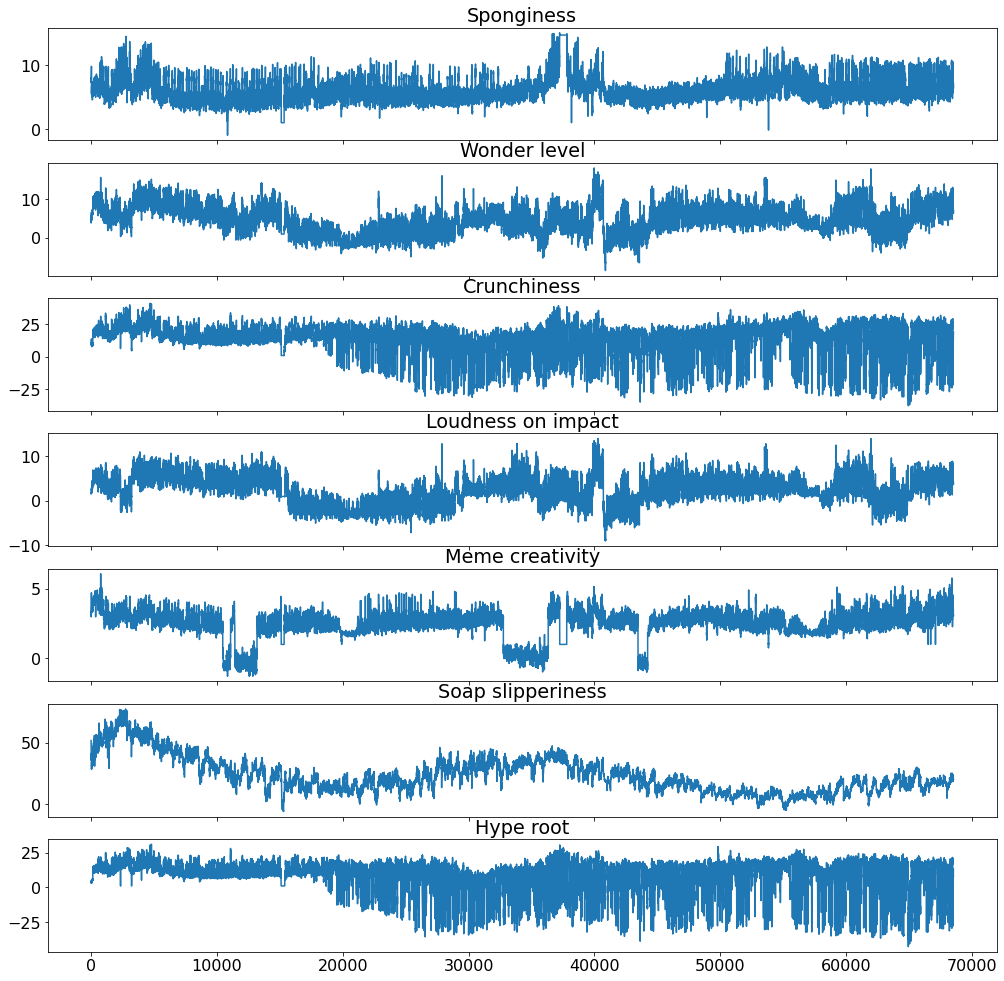

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(43528, 7) (5000, 7)


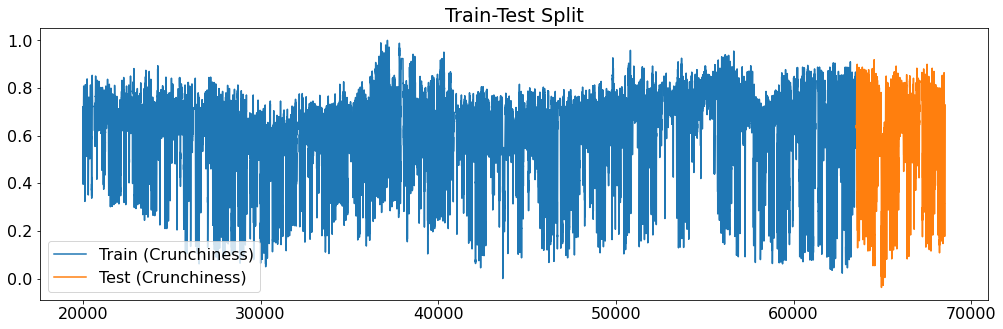

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[20000:-test_size] # discarding first 20 000 samples
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.163660
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -0.972080
Soap slipperiness     -5.188480
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           39.359280
Loudness on impact    14.035980
Meme creativity        5.146680
Soap slipperiness     47.360479
Hype root             30.493220
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 90, 7)


In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

# Forecasting

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8522, 90, 7), (8522, 864, 7), (818, 90, 7), (818, 864, 7))

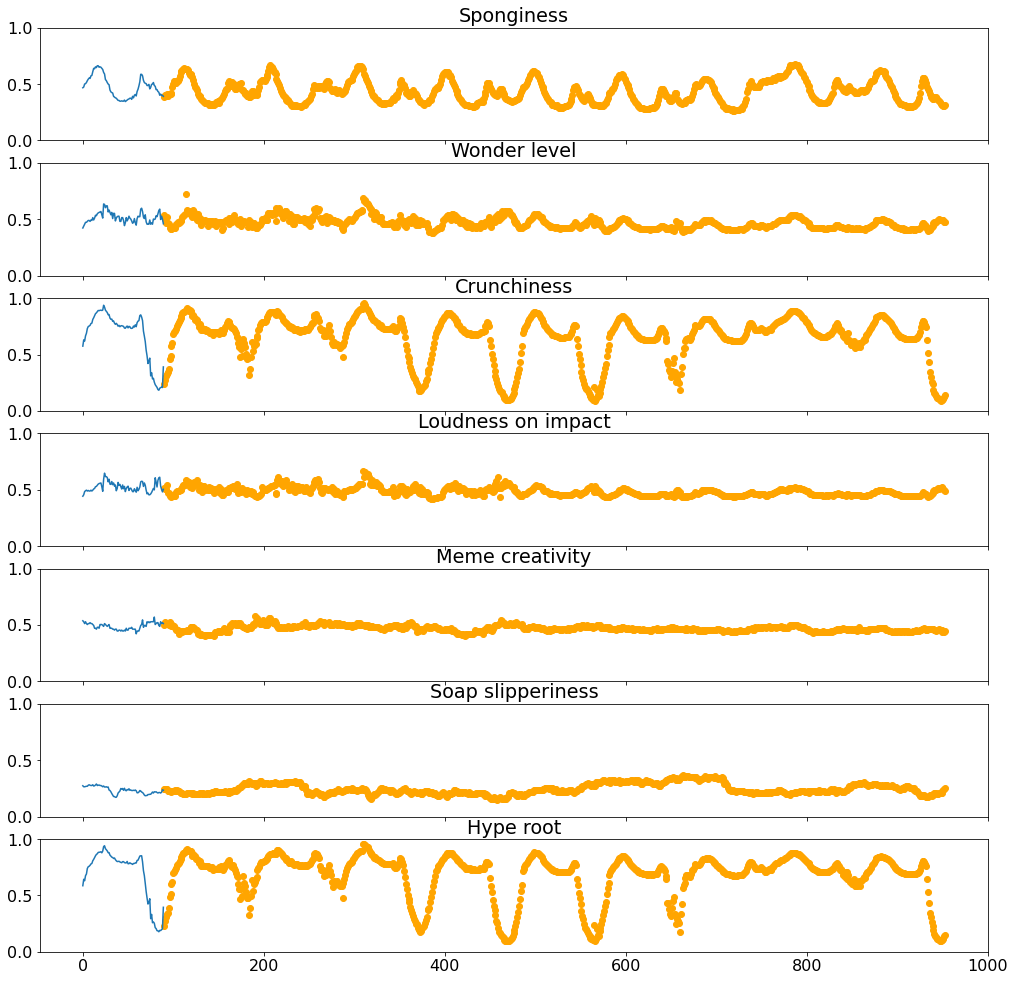

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 7)


(None, 90, 256)
(None, 90, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 256)          139264    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 90, 256)          16449     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6048)              1554336   
                             

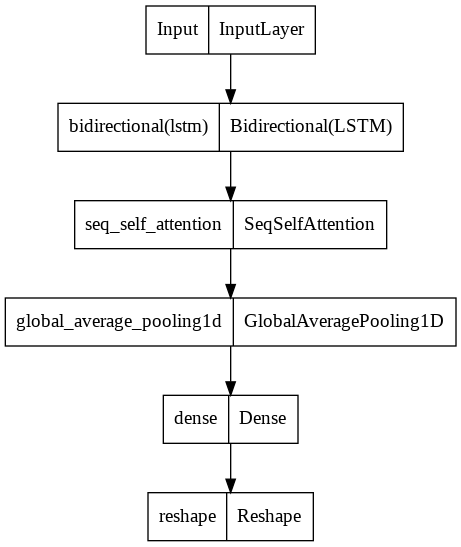

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

#Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# restore checkpoints:
#model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
958/959 [============================>.] - ETA: 0s - loss: 0.0699 - mae: 0.1763 - rmse: 0.2644

959/959 [==============================] - 30s 25ms/step - loss: 0.0699 - mae: 0.1763 - rmse: 0.2643 - val_loss: 0.0435 - val_mae: 0.1399 - val_rmse: 0.2085 - lr: 0.0010
Epoch 2/500
958/959 [============================>.] - ETA: 0s - loss: 0.0285 - mae: 0.1068 - rmse: 0.1688

959/959 [==============================] - 23s 24ms/step - loss: 0.0285 - mae: 0.1068 - rmse: 0.1689 - val_loss: 0.0303 - val_mae: 0.1169 - val_rmse: 0.1740 - lr: 0.0010
Epoch 3/500
955/959 [============================>.] - ETA: 0s - loss: 0.0223 - mae: 0.0941 - rmse: 0.1494

959/959 [==============================] - 23s 24ms/step - loss: 0.0223 - mae: 0.0941 - rmse: 0.1494 - val_loss: 0.0256 - val_mae: 0.1087 - val_rmse: 0.1601 - lr: 0.0010
Epoch 4/500
959/959 [==============================] - ETA: 0s - loss: 0.0186 - mae: 0.0858 - rmse: 0.1364

959/959 [==============================] - 23s 24ms/step - loss: 0.0186 - mae: 0.0858 - rmse: 0.1364 - val_loss: 0.0236 - val_mae: 0.1056 - val_rmse: 0.1535 - lr: 0.0010
Epoch 5/500
955/959 [============================>.] - ETA: 0s - loss: 0.0166 - mae: 0.0814 - rmse: 0.1287

959/959 [==============================] - 23s 24ms/step - loss: 0.0166 - mae: 0.0814 - rmse: 0.1287 - val_loss: 0.0221 - val_mae: 0.1038 - val_rmse: 0.1486 - lr: 0.0010
Epoch 6/500
955/959 [============================>.] - ETA: 0s - loss: 0.0149 - mae: 0.0778 - rmse: 0.1221

959/959 [==============================] - 23s 24ms/step - loss: 0.0149 - mae: 0.0779 - rmse: 0.1221 - val_loss: 0.0212 - val_mae: 0.1016 - val_rmse: 0.1456 - lr: 0.0010
Epoch 7/500
955/959 [============================>.] - ETA: 0s - loss: 0.0132 - mae: 0.0743 - rmse: 0.1151

959/959 [==============================] - 23s 24ms/step - loss: 0.0132 - mae: 0.0743 - rmse: 0.1150 - val_loss: 0.0195 - val_mae: 0.0977 - val_rmse: 0.1395 - lr: 0.0010
Epoch 8/500
957/959 [============================>.] - ETA: 0s - loss: 0.0119 - mae: 0.0717 - rmse: 0.1092

959/959 [==============================] - 23s 24ms/step - loss: 0.0119 - mae: 0.0717 - rmse: 0.1092 - val_loss: 0.0188 - val_mae: 0.0974 - val_rmse: 0.1369 - lr: 0.0010
Epoch 9/500
956/959 [============================>.] - ETA: 0s - loss: 0.0109 - mae: 0.0692 - rmse: 0.1044

959/959 [==============================] - 23s 24ms/step - loss: 0.0109 - mae: 0.0692 - rmse: 0.1044 - val_loss: 0.0184 - val_mae: 0.0964 - val_rmse: 0.1358 - lr: 0.0010
Epoch 10/500
959/959 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0677 - rmse: 0.1007

959/959 [==============================] - 23s 24ms/step - loss: 0.0101 - mae: 0.0677 - rmse: 0.1007 - val_loss: 0.0169 - val_mae: 0.0945 - val_rmse: 0.1299 - lr: 0.0010
Epoch 11/500
958/959 [============================>.] - ETA: 0s - loss: 0.0097 - mae: 0.0667 - rmse: 0.0985

959/959 [==============================] - 23s 24ms/step - loss: 0.0097 - mae: 0.0667 - rmse: 0.0985 - val_loss: 0.0174 - val_mae: 0.0944 - val_rmse: 0.1318 - lr: 0.0010
Epoch 12/500
957/959 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0652 - rmse: 0.0953

959/959 [==============================] - 23s 24ms/step - loss: 0.0091 - mae: 0.0652 - rmse: 0.0953 - val_loss: 0.0170 - val_mae: 0.0943 - val_rmse: 0.1303 - lr: 0.0010
Epoch 13/500
956/959 [============================>.] - ETA: 0s - loss: 0.0087 - mae: 0.0640 - rmse: 0.0931

959/959 [==============================] - 23s 24ms/step - loss: 0.0087 - mae: 0.0640 - rmse: 0.0932 - val_loss: 0.0161 - val_mae: 0.0921 - val_rmse: 0.1268 - lr: 0.0010
Epoch 14/500
956/959 [============================>.] - ETA: 0s - loss: 0.0082 - mae: 0.0628 - rmse: 0.0907

959/959 [==============================] - 23s 24ms/step - loss: 0.0082 - mae: 0.0628 - rmse: 0.0908 - val_loss: 0.0163 - val_mae: 0.0930 - val_rmse: 0.1276 - lr: 0.0010
Epoch 15/500
958/959 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0618 - rmse: 0.0890

959/959 [==============================] - 23s 24ms/step - loss: 0.0079 - mae: 0.0618 - rmse: 0.0890 - val_loss: 0.0158 - val_mae: 0.0921 - val_rmse: 0.1255 - lr: 0.0010
Epoch 16/500
956/959 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0615 - rmse: 0.0886

959/959 [==============================] - 23s 24ms/step - loss: 0.0078 - mae: 0.0615 - rmse: 0.0886 - val_loss: 0.0161 - val_mae: 0.0926 - val_rmse: 0.1268 - lr: 0.0010
Epoch 17/500
958/959 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0609 - rmse: 0.0872

959/959 [==============================] - 23s 24ms/step - loss: 0.0076 - mae: 0.0609 - rmse: 0.0872 - val_loss: 0.0179 - val_mae: 0.0976 - val_rmse: 0.1340 - lr: 0.0010
Epoch 18/500
957/959 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0601 - rmse: 0.0856

959/959 [==============================] - 23s 24ms/step - loss: 0.0073 - mae: 0.0601 - rmse: 0.0856 - val_loss: 0.0158 - val_mae: 0.0923 - val_rmse: 0.1258 - lr: 0.0010
Epoch 19/500
958/959 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0601 - rmse: 0.0856

959/959 [==============================] - 23s 24ms/step - loss: 0.0073 - mae: 0.0601 - rmse: 0.0856 - val_loss: 0.0161 - val_mae: 0.0937 - val_rmse: 0.1267 - lr: 0.0010
Epoch 20/500
956/959 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0596 - rmse: 0.0845

959/959 [==============================] - 23s 24ms/step - loss: 0.0071 - mae: 0.0596 - rmse: 0.0846 - val_loss: 0.0158 - val_mae: 0.0932 - val_rmse: 0.1257 - lr: 0.0010
Epoch 21/500
958/959 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0562 - rmse: 0.0793

959/959 [==============================] - 23s 24ms/step - loss: 0.0063 - mae: 0.0562 - rmse: 0.0792 - val_loss: 0.0153 - val_mae: 0.0911 - val_rmse: 0.1238 - lr: 5.0000e-04
Epoch 22/500
955/959 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0555 - rmse: 0.0781

959/959 [==============================] - 23s 24ms/step - loss: 0.0061 - mae: 0.0555 - rmse: 0.0780 - val_loss: 0.0155 - val_mae: 0.0922 - val_rmse: 0.1246 - lr: 5.0000e-04
Epoch 23/500
959/959 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0552 - rmse: 0.0776

959/959 [==============================] - 23s 24ms/step - loss: 0.0060 - mae: 0.0552 - rmse: 0.0776 - val_loss: 0.0160 - val_mae: 0.0930 - val_rmse: 0.1266 - lr: 5.0000e-04
Epoch 24/500
957/959 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0546 - rmse: 0.0766

959/959 [==============================] - 23s 24ms/step - loss: 0.0059 - mae: 0.0546 - rmse: 0.0766 - val_loss: 0.0155 - val_mae: 0.0922 - val_rmse: 0.1246 - lr: 5.0000e-04
Epoch 25/500
958/959 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0547 - rmse: 0.0767

959/959 [==============================] - 23s 24ms/step - loss: 0.0059 - mae: 0.0547 - rmse: 0.0767 - val_loss: 0.0160 - val_mae: 0.0932 - val_rmse: 0.1263 - lr: 5.0000e-04
Epoch 26/500
959/959 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0544 - rmse: 0.0763

959/959 [==============================] - 23s 24ms/step - loss: 0.0058 - mae: 0.0544 - rmse: 0.0763 - val_loss: 0.0165 - val_mae: 0.0944 - val_rmse: 0.1286 - lr: 5.0000e-04
Epoch 27/500
958/959 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0527 - rmse: 0.0740

959/959 [==============================] - 23s 24ms/step - loss: 0.0055 - mae: 0.0527 - rmse: 0.0740 - val_loss: 0.0160 - val_mae: 0.0931 - val_rmse: 0.1265 - lr: 2.5000e-04
Epoch 28/500
956/959 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0523 - rmse: 0.0732

959/959 [==============================] - 23s 24ms/step - loss: 0.0054 - mae: 0.0523 - rmse: 0.0732 - val_loss: 0.0162 - val_mae: 0.0936 - val_rmse: 0.1273 - lr: 2.5000e-04
Epoch 29/500
955/959 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0521 - rmse: 0.0728

959/959 [==============================] - 23s 24ms/step - loss: 0.0053 - mae: 0.0521 - rmse: 0.0728 - val_loss: 0.0169 - val_mae: 0.0957 - val_rmse: 0.1300 - lr: 2.5000e-04
Epoch 30/500
955/959 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0520 - rmse: 0.0727

959/959 [==============================] - 23s 24ms/step - loss: 0.0053 - mae: 0.0520 - rmse: 0.0727 - val_loss: 0.0161 - val_mae: 0.0936 - val_rmse: 0.1270 - lr: 2.5000e-04
Epoch 31/500
955/959 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0518 - rmse: 0.0723

959/959 [==============================] - 23s 24ms/step - loss: 0.0052 - mae: 0.0518 - rmse: 0.0723 - val_loss: 0.0166 - val_mae: 0.0948 - val_rmse: 0.1288 - lr: 2.5000e-04
Epoch 32/500
955/959 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0510 - rmse: 0.0713

959/959 [==============================] - 23s 24ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0713 - val_loss: 0.0169 - val_mae: 0.0957 - val_rmse: 0.1302 - lr: 1.2500e-04
Epoch 33/500
955/959 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0509 - rmse: 0.0711

959/959 [==============================] - 23s 24ms/step - loss: 0.0051 - mae: 0.0509 - rmse: 0.0711 - val_loss: 0.0163 - val_mae: 0.0941 - val_rmse: 0.1278 - lr: 1.2500e-04
Epoch 34/500
957/959 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0508 - rmse: 0.0709

959/959 [==============================] - 23s 24ms/step - loss: 0.0050 - mae: 0.0508 - rmse: 0.0709 - val_loss: 0.0166 - val_mae: 0.0950 - val_rmse: 0.1288 - lr: 1.2500e-04
Epoch 35/500
959/959 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0507 - rmse: 0.0707

959/959 [==============================] - 23s 24ms/step - loss: 0.0050 - mae: 0.0507 - rmse: 0.0707 - val_loss: 0.0168 - val_mae: 0.0953 - val_rmse: 0.1295 - lr: 1.2500e-04
Epoch 36/500
959/959 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0506 - rmse: 0.0706

959/959 [==============================] - 23s 24ms/step - loss: 0.0050 - mae: 0.0506 - rmse: 0.0706 - val_loss: 0.0168 - val_mae: 0.0956 - val_rmse: 0.1298 - lr: 1.2500e-04
Epoch 37/500
959/959 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0502 - rmse: 0.0701

959/959 [==============================] - 23s 24ms/step - loss: 0.0049 - mae: 0.0502 - rmse: 0.0701 - val_loss: 0.0168 - val_mae: 0.0954 - val_rmse: 0.1295 - lr: 6.2500e-05
Epoch 38/500
955/959 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0501 - rmse: 0.0700

959/959 [==============================] - 23s 24ms/step - loss: 0.0049 - mae: 0.0501 - rmse: 0.0700 - val_loss: 0.0169 - val_mae: 0.0960 - val_rmse: 0.1302 - lr: 6.2500e-05
Epoch 39/500
957/959 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0501 - rmse: 0.0699

959/959 [==============================] - 23s 24ms/step - loss: 0.0049 - mae: 0.0501 - rmse: 0.0699 - val_loss: 0.0168 - val_mae: 0.0956 - val_rmse: 0.1298 - lr: 6.2500e-05
Epoch 40/500
958/959 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0500 - rmse: 0.0698

959/959 [==============================] - 23s 24ms/step - loss: 0.0049 - mae: 0.0500 - rmse: 0.0698 - val_loss: 0.0169 - val_mae: 0.0959 - val_rmse: 0.1302 - lr: 6.2500e-05
Epoch 41/500
955/959 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0500 - rmse: 0.0697

959/959 [==============================] - 23s 24ms/step - loss: 0.0049 - mae: 0.0500 - rmse: 0.0697 - val_loss: 0.0168 - val_mae: 0.0956 - val_rmse: 0.1298 - lr: 6.2500e-05
Epoch 42/500
958/959 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0498 - rmse: 0.0695

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0498 - rmse: 0.0695 - val_loss: 0.0170 - val_mae: 0.0960 - val_rmse: 0.1305 - lr: 3.1250e-05
Epoch 43/500
956/959 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0497 - rmse: 0.0694

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0497 - rmse: 0.0694 - val_loss: 0.0172 - val_mae: 0.0966 - val_rmse: 0.1313 - lr: 3.1250e-05
Epoch 44/500
959/959 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0497 - rmse: 0.0694

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0497 - rmse: 0.0694 - val_loss: 0.0172 - val_mae: 0.0965 - val_rmse: 0.1312 - lr: 3.1250e-05
Epoch 45/500
959/959 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0497 - rmse: 0.0693

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0497 - rmse: 0.0693 - val_loss: 0.0172 - val_mae: 0.0966 - val_rmse: 0.1313 - lr: 3.1250e-05
Epoch 46/500
956/959 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0497 - rmse: 0.0693

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0497 - rmse: 0.0693 - val_loss: 0.0171 - val_mae: 0.0962 - val_rmse: 0.1306 - lr: 3.1250e-05
Epoch 47/500
958/959 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0496 - rmse: 0.0691

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0496 - rmse: 0.0691 - val_loss: 0.0172 - val_mae: 0.0965 - val_rmse: 0.1311 - lr: 1.5625e-05
Epoch 48/500
959/959 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0495 - rmse: 0.0691

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0691 - val_loss: 0.0171 - val_mae: 0.0964 - val_rmse: 0.1309 - lr: 1.5625e-05
Epoch 49/500
957/959 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0495 - rmse: 0.0691

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0691 - val_loss: 0.0173 - val_mae: 0.0968 - val_rmse: 0.1315 - lr: 1.5625e-05
Epoch 50/500
956/959 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0495 - rmse: 0.0691

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0691 - val_loss: 0.0173 - val_mae: 0.0968 - val_rmse: 0.1314 - lr: 1.5625e-05
Epoch 51/500
959/959 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0495 - rmse: 0.0690

959/959 [==============================] - 23s 24ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0690 - val_loss: 0.0172 - val_mae: 0.0965 - val_rmse: 0.1311 - lr: 1.5625e-05


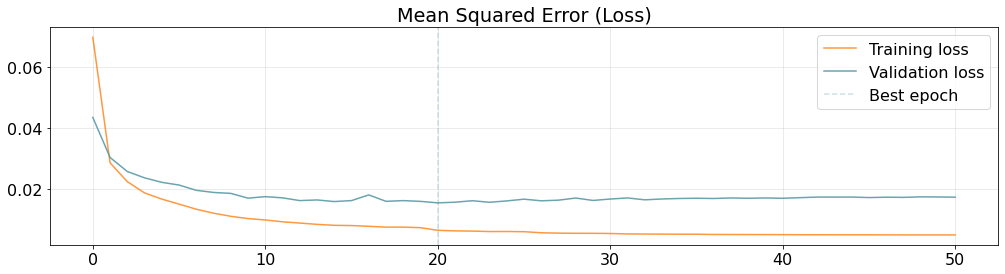

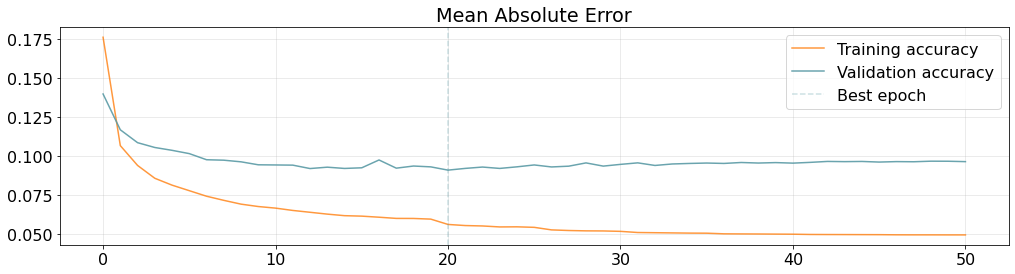

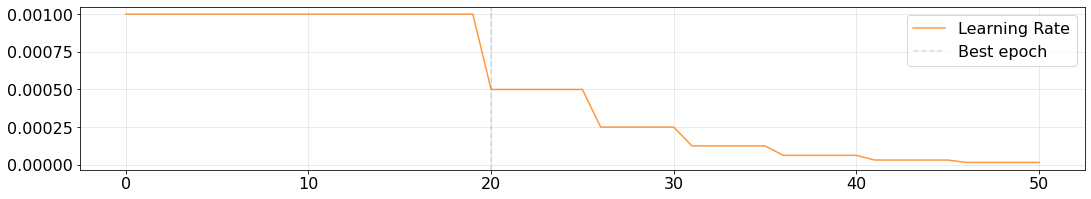

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Models/'+title)
#model = tfk.models.load_model('Models/'+title)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(818, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.015003029>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.092656754>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

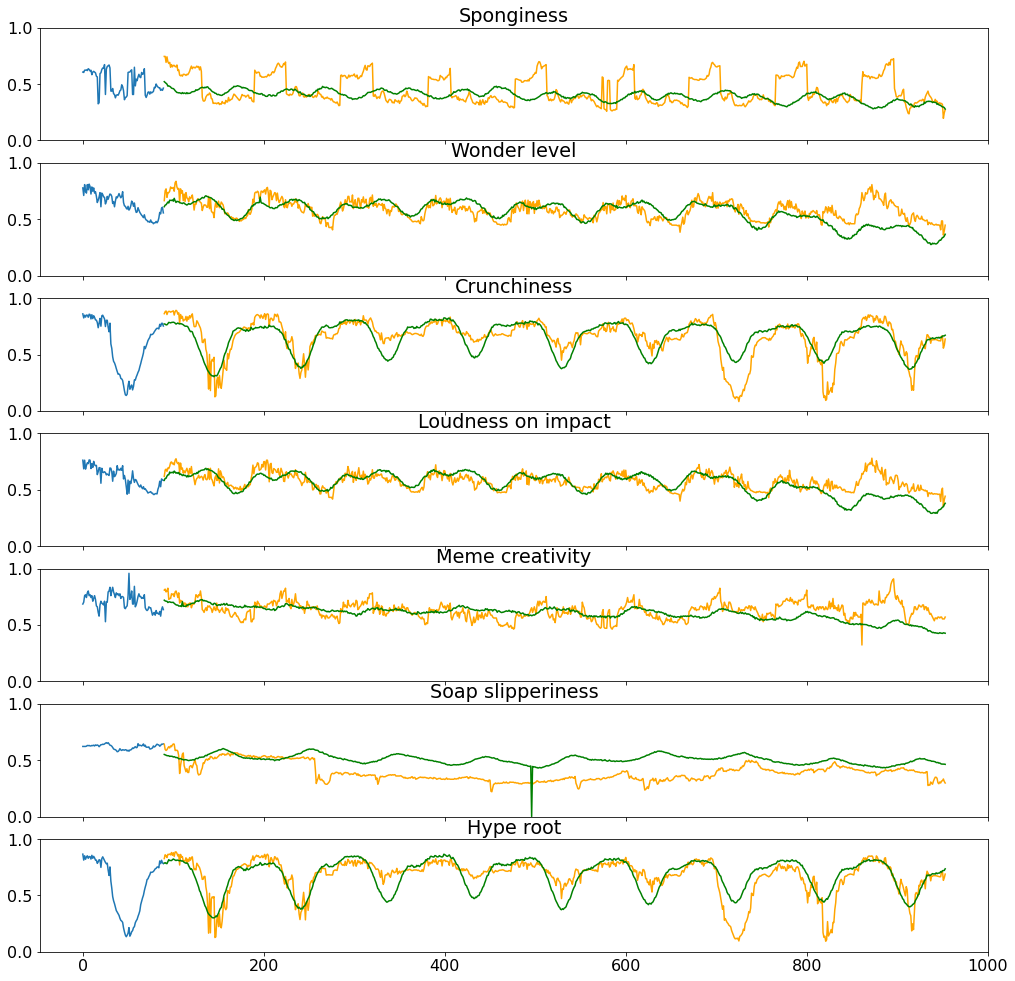

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)